# import required modules

In [1]:
import torch
import numpy as np
import os
from utils4image.dataloaders import NSDImageDataset
from torch.utils.data import DataLoader
from utils4image.utils import load_generator
from utils4image.eva_utils import load_meshmodel
import matplotlib.pyplot as plt

Faiss library not found!


# set hyperparameters

In [2]:
scale = 1
mapping = 'meshpool'
optim = 'adamw'
lr = 1e-4
decay = 0.1
dropout_rate = 0.5
fdim = 32
indim = 32
n_hidden_layer = 3
recon_w = 1e-6
kld_w = 1e-8
annealing_epochs = 10
kld_start_epoch = 0
in_feature_w = 0
out_feature_w = 1
b2f_fix = True
variation = True
combined_type = 'variation' if variation else 'direct'
factor = 1

device = torch.device('cuda')

subject = 1
batch_size = 10

# load model and data

In [3]:
# modify according to your own path
ckpt_dir = f'./decoding_ckpt/S{subject}/image_decoding/{combined_type}/'
model_base = '%s_%s_lr%s_dc%s_dp%s_fd%d_ind%d_layer%d_rw%s_ifw%s_ofw%s_kldw%s_ae%d_kldse%d_vsf%s'% \
(mapping, optim, "{:.0e}".format(lr),"{:.0e}".format(decay), "{:.0e}".format(dropout_rate),
fdim, indim, n_hidden_layer, "{:.0e}".format(recon_w),  "{:.0e}".format(in_feature_w), 
"{:.0e}".format(out_feature_w), "{:.0e}".format(kld_w), annealing_epochs, kld_start_epoch, "{:.0e}".format(factor))

# load model
model_base = (model_base + '_fixb2f') if b2f_fix else (model_base + '_ftb2f')
model = load_meshmodel(subject, 'image', fdim, indim, n_hidden_layer, dropout_rate, model_base).to(device)

/home/zg243/image_generation/ic_gan/utils4image/ugscnn_utils.py:214: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/torch/csrc/utils/tensor_new.cpp:201.)
  i = torch.LongTensor([m.row, m.col])


Pegging all root folders to base root /home/zg243/image_generation/ic_gan/pretrained_models
For name best  best0  we have an FID:  22.453704833984375
Checkpoint with name  best1  not in folder.
Final name selected is  best0
Loading best0 weights from /home/zg243/image_generation/ic_gan/pretrained_models/icgan_biggan_imagenet_res256...
Experiment name is icgan_biggan_imagenet_res256
Adding attention layer in G at resolution 64
Param count for Gs initialized parameters: 90014147
Loading weights...
Loading best0 weights from /home/zg243/image_generation/ic_gan/pretrained_models/icgan_biggan_imagenet_res256...
Putting G in eval mode..
Number of parameters: 90014340


Using cache found in /home/zg243/.cache/torch/hub/facebookresearch_swav_main


24


In [4]:
# load test set
test_dataset = NSDImageDataset(mode='test', test_subject=subject)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# reconstruct images

In [6]:
pred_feat = []
pred_mu = []
pred_logvar = []
true_img = []
for i, (data, target, target_f) in enumerate(test_loader):
    pred, feat, mu, logvar = model(data.to(device))
    pred_feat.append(feat.detach().cpu())
    pred_mu.append(mu.detach().cpu())
    pred_logvar.append(logvar.detach().cpu())
    true_img.append(target.detach().cpu().numpy())
    # put break here just to reconstruct one batch for display
    break

del data # to free some memory
pred_mu = torch.vstack(pred_mu)
pred_logvar = torch.vstack(pred_logvar)*scale
pred_feat = torch.vstack(pred_feat)
true_img = np.vstack(true_img)

pf_pz = [] #(1000, 3, 256, 256)
for i in range(len(test_loader)):
    pf = pred_feat[i*batch_size:(i+1)*batch_size].to(device)
    pz = pred_mu[i*batch_size:(i+1)*batch_size].to(device)
    img = model.generator(pz, None, pf).detach().cpu().numpy()
    pf_pz.append(img)
    # put break here just to reconstruct one batch for display
    break
pf_pz = np.vstack(pf_pz)
pf_pz = (pf_pz+1)/2

pf_pz = np.moveaxis(pf_pz, 1, -1)
true_img = np.moveaxis(true_img, 1, -1)

# display ground truth and recon

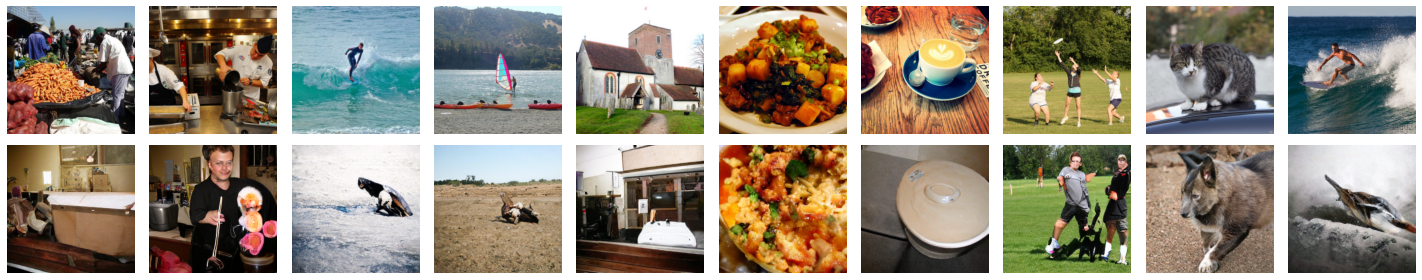

In [12]:
plt.figure(figsize=(20,4))

# plot ground truth
for i in range(batch_size):
    plt.subplot(2, batch_size, i+1)
    img = (true_img[i] + 1)/2
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()

#plot recon
for i in range(batch_size):
    plt.subplot(2, batch_size, i+11)
    img = pf_pz[i]
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()

# save recon

In [ ]:
# modify according to your own path
res_dir = f'./decoding_result/S{subject}/image_decoding/'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

# save reconstructed images
np.save(res_dir + model_base + f'_pred_imgs.npy', n_pf_pz)